In [ ]:
#!pip install mplfinance

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

In [9]:
df = pd.read_csv('crypto-markets.csv')
#df.info()
df.head()

# Transforming date to date object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Getting a dataframe containing only the latest date's data for each currency

latest_df = df[df['date'] == max(df['date'])]
print("Latest crypto data \n \n",latest_df.head())

print("Number of cryptocurrencies listed: ",latest_df['symbol'].nunique())

# starting dates for all currencies
start_df = pd.DataFrame({'start_date' : df.groupby( [ "name", "ranknow"] )['date'].min()}).reset_index()

# List the oldest ones
print("Oldest Cryptocurrencies\n", start_df.sort_values(['start_date']).head())

print("Top 10 currencies: \n",latest_df[latest_df['ranknow'] <= 10].groupby('ranknow').name.unique())


Latest crypto data
Latest crypto data 
 
               slug symbol          name       date  ranknow         open  \
1744       bitcoin    BTC       Bitcoin 2018-02-05        1  8270.540000   
2658      ethereum    ETH      Ethereum 2018-02-05        2   834.960000   
4305        ripple    XRP        Ripple 2018-02-05        3     0.825943   
4503  bitcoin-cash    BCH  Bitcoin Cash 2018-02-05        4  1159.890000   
4631       cardano    ADA       Cardano 2018-02-05        5     0.385044   

             high          low        close      volume        market  \
1744  8364.840000  6756.680000  6955.270000  9285290000  139325000000   
2658   856.650000   644.600000   697.950000  4269530000   81337400000   
4305     0.833866     0.675827     0.691799  1286180000   32219400000   
4503  1172.700000   839.950000   887.410000   568117000   19659800000   
4631     0.399523     0.319646     0.327371   658548000    9983060000   

      close_ratio   spread  
1744       0.1235  1608.16  
2658

### Plotting the top 10 currencies according to market valuation

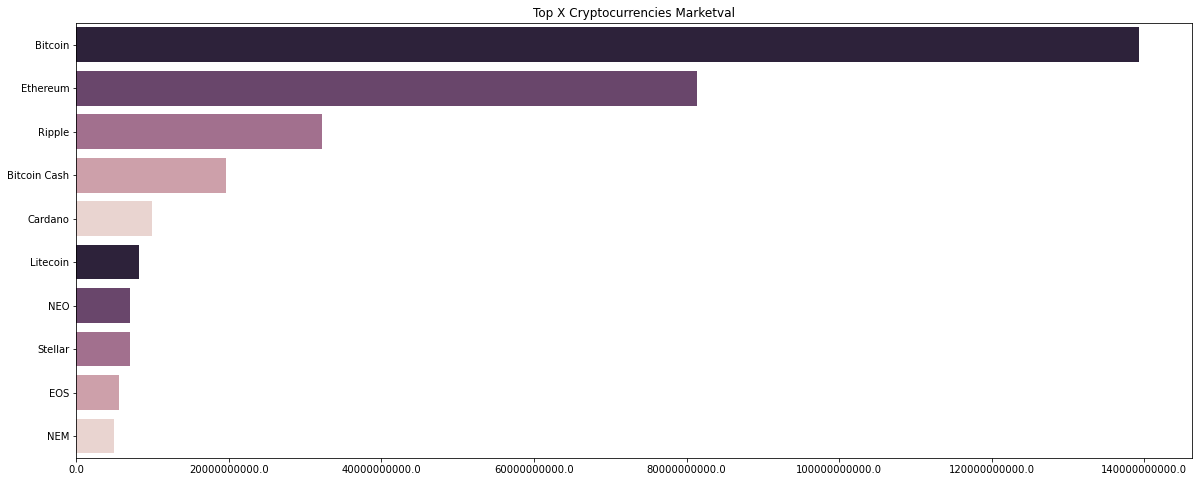

In [10]:
name = latest_df['name'].unique()
currency  = []
marketval = []
x_currencies = name[:10]
for i, cn in enumerate(x_currencies):
     filtered = latest_df[(latest_df['name']==str(cn))]
     currency.append(str(cn))
     marketval.append(filtered['market'].values[0])

f, ax = plt.subplots(figsize=(20, 8)) 
g = sns.barplot( y = currency, x = marketval, palette=sns.cubehelix_palette(5, reverse=True))
plt.title("Top 10 Cryptocurrencies Marketval")
ax.set_xticklabels(ax.get_xticks())
fig=plt.gcf()
plt.show()

### Candlestick chart for Bitcoin

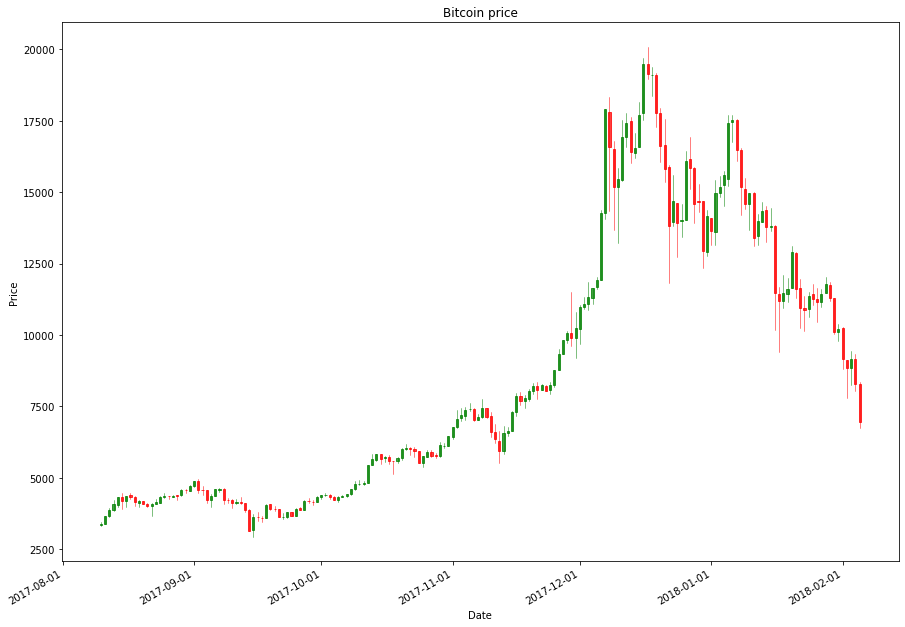

In [11]:
rank = 1
months = 6

name = df[df.ranknow == rank].iloc[-1]['name']
filtered_df = df[(df['ranknow'] == rank) & (df['date'] > (max(df['date']) - timedelta(days=30*months)))]
OHLCfiltered_df = filtered_df[['date','open','high','low','close']]
OHLCfiltered_df['date'] = mdates.date2num(OHLCfiltered_df['date'].dt.date)

f,ax=plt.subplots(figsize=(15,11))
ax.xaxis_date()
candlestick_ohlc(ax, OHLCfiltered_df.values, width=0.5, colorup='g', colordown='r',alpha=0.75)

plt.xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title(name + " price")
plt.ylabel("Price")
plt.show()


### Moving average chart for Bitcoin

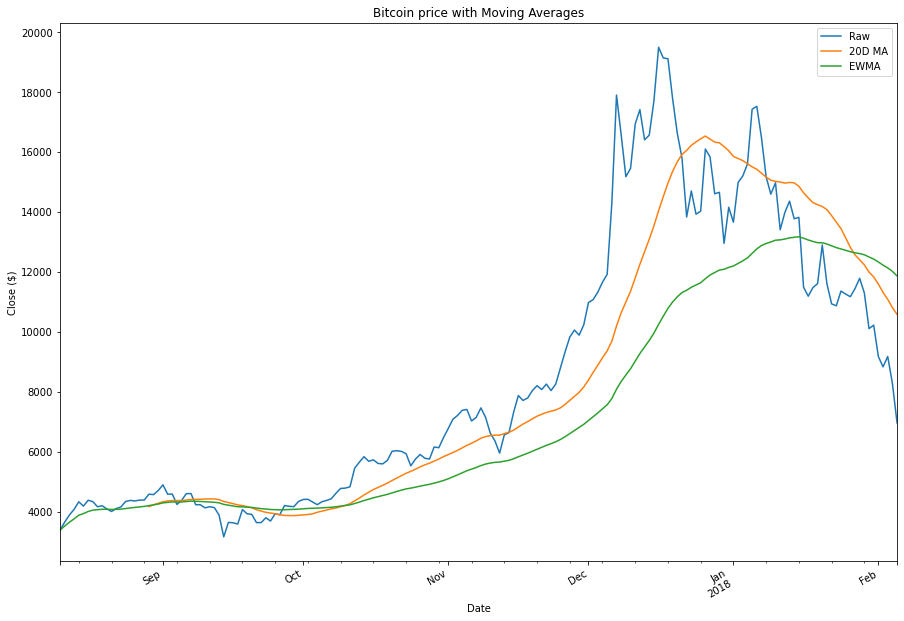

In [12]:
rank = 1
months = 6
name = df[df.ranknow == rank].iloc[-1]['name']
filtered_df = df[(df['ranknow'] == rank) & (df['date'] > (max(df['date']) - timedelta(days=30*months)))]

filtered_df.set_index('date', inplace=True)

f, ax = plt.subplots(figsize=(15,11))
filtered_df.close.plot(label='Raw', ax=ax)
filtered_df.close.rolling(20).mean().plot(label='20D MA', ax=ax)
filtered_df.close.ewm(alpha=0.03).mean().plot(label='EWMA', ax=ax)

plt.title(name + " price with Moving Averages")
plt.legend()
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
plt.ylabel("Close ($)")
plt.show()

In [13]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

### Preparation of the data base

In [14]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
df.head()

# Extracting bitcoin data
btc=df[df['symbol']=='BTC']
btc.drop(['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'],axis=1,inplace=True)
btc.head()

,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21


In [16]:
btc_month = btc.resample('M').mean()
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
print("Dickey–Fuller test for close_box: p=%f" % adfuller(btc_month.close_box)[1])
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test for box_diff_seasonal_12: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test for box_diff_seasonal_3: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

Dickey–Fuller test for close_box: p=0.494475
Dickey–Fuller test for box_diff_seasonal_12: p=0.661446
Dickey–Fuller test for box_diff_seasonal_3: p=0.018033


### Initial approximation of parameters

  parameters         aic
3     (1, 0) -220.113589
1     (0, 1) -219.765332
4     (1, 1) -218.164004
6     (2, 0) -218.152069
2     (0, 2) -217.954259
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   59
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 112.057
Date:                Tue, 11 Jan 2022   AIC                           -220.114
Time:                        14:44:55   BIC                           -215.993
Sample:                    04-30-2013   HQIC                          -218.508
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3743      0.152      2.470      0.014      

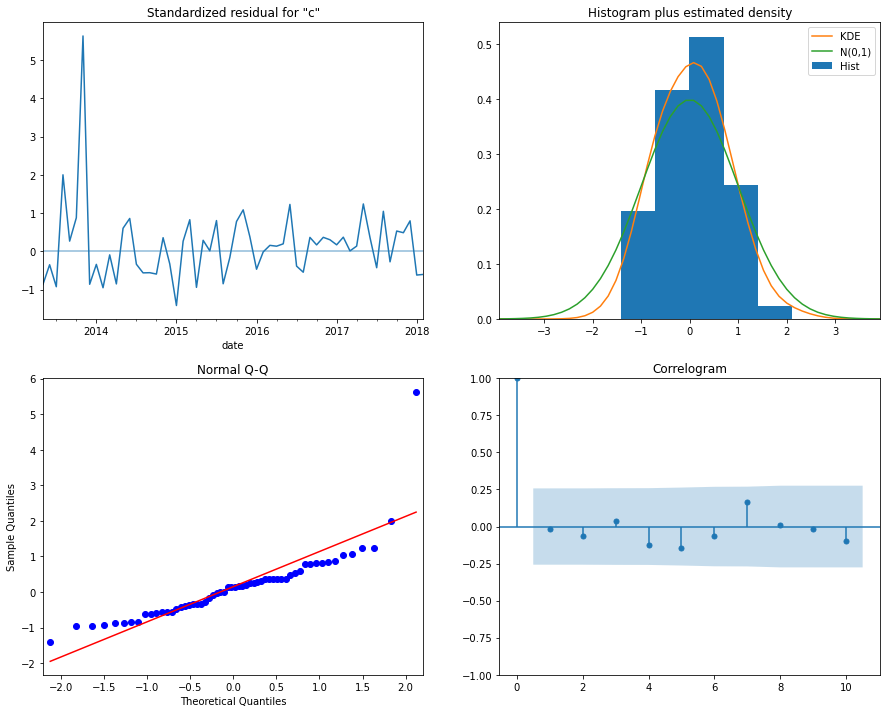

In [17]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

best_model.plot_diagnostics(figsize=(15, 12))
plt.show()